In [20]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy.random as npr

from model import make_model, sample_model, plot_forestplots

sns.set_context('poster')
sns.set_style('white')
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simulation Data

In systematically measuring genotype-phenotype data, how will the data be collected, stored and analyzed? Is a small laptop enough to model the fold change calculations locally? I explore this in the following notebook.

In [26]:
def make_simulated_data(n_reps_low, n_reps_high, n_genotypes):
    means = npr.randint(low=10, high=100, size=n_genotypes)
    means = means * (means > 0)  # negative activities are not captured
    sds = npr.random(size=n_genotypes) * 10
    num_measurements = npr.randint(low=n_reps_low, high=n_reps_high, size=n_genotypes)

    # Create simulated data.
    data = []
    indices = []

    for i in range(n_genotypes):
        n = num_measurements[i]
        mean = means[i]
        sd = sds[i]

        measurements = npr.normal(loc=mean, scale=sd, size=n)
        # print(measurements)
        measurements = measurements * (measurements > 0)
        # print(measurements)

        data.extend(measurements.tolist())
        indices.extend([i] * n)

    # Add baseline measurements (bl_measures)
    n_bl_measures = n_reps_high - 1
    bl_measures = npr.normal(loc=1.0, scale=0.1, size=n_bl_measures)
    bl_measures = bl_measures * (bl_measures > 0)
    data.extend(bl_measures)
    indices.extend([n_genotypes] * n_bl_measures)
    num_measurements = np.append(num_measurements, n_bl_measures)
    means = np.append(means, bl_measures.mean())
    sds = np.append(sds, bl_measures.std())

    # Add pos_ctrl measurements (pc_measures)
    n_pc_measures = n_reps_high - 1
    pc_measures = npr.normal(loc=20.0, scale=1, size=n_pc_measures)
    pc_measures = pc_measures * (pc_measures > 0)
    data.extend(pc_measures)
    indices.extend([n_genotypes + 1] * n_pc_measures)
    num_measurements = np.append(num_measurements, n_pc_measures)
    means = np.append(means, pc_measures.mean())
    sds = np.append(sds, pc_measures.std())

    # convert indices to a numpy array
    indices = np.array(indices)

    return data, indices, num_measurements, means, sds,

In [27]:
# Set n_genotypes > 1000 to obtain estimates of variance in error as a function of num_measurements
# Set n_genotypes < 15 to obtain diagnostic plots (traceplot) and comparison of modelled to actual.
# You've been forewarned - for the diagnostics and modelled, plotting with > 100 takes a while...
n_genotypes = 5000
n_reps = 2  # number of replicate measurements per sample

sim_data = make_simulated_data(n_genotypes=n_genotypes, n_reps_low=2, n_reps_high=15)
data, indices, num_measurements, means, sds = sim_data

In [28]:
# Compute the "actual" Z'-factor for the assay.
zp_det = 1 - (3 * sds[-2] + 3 * sds[-1]) / np.abs(means[-2] - means[-1])
zp_det

0.75552059864635035

In [29]:
model = make_model(n_genotypes, data, indices)

Applied log-transform to upper and added transformed upper_log_ to model.
Applied interval-transform to fold and added transformed fold_interval_ to model.
Applied log-transform to sigma and added transformed sigma_log_ to model.


In [30]:
%%time

trace = sample_model(model, n_genotypes)

Iteration 0 [0%]: ELBO = -205425389.62
Iteration 30000 [10%]: Average ELBO = -18074495.35
Iteration 60000 [20%]: Average ELBO = -137656.07
Iteration 90000 [30%]: Average ELBO = -134127.8
Iteration 120000 [40%]: Average ELBO = -133493.26
Iteration 150000 [50%]: Average ELBO = -133278.58
Iteration 180000 [60%]: Average ELBO = -133232.87
Iteration 210000 [70%]: Average ELBO = -133224.25
Iteration 240000 [80%]: Average ELBO = -133217.27
Iteration 270000 [90%]: Average ELBO = -133215.49
Finished [100%]: Average ELBO = -133214.5
CPU times: user 30min 27s, sys: 36.3 s, total: 31min 3s
Wall time: 39min 40s


In [31]:
if n_genotypes <= 15:
    plot_forestplots(trace)

In [32]:
if n_genotypes <= 15:
    pm.summary(trace)

In [33]:
if n_genotypes <= 15:
    pm.traceplot(trace)

# Error in Estimated Mean

What is the error in estimated mean as a function of the number of measurements?

In [34]:
num_measurements

array([ 3, 14,  5, ...,  3, 14, 14])

In [35]:
trace['fold'].mean(axis=0) - means

array([  5.53774301e+00,   5.32765005e-01,  -1.28463355e+00, ...,
        -6.19365439e-01,  -3.06191584e-03,   2.46455256e-02])

In [36]:
import pandas as pd
errors_df = pd.DataFrame([num_measurements, (trace['fold'].mean(axis=0) - means)]).T
errors_df.columns = ['num_measurements', 'error_means']
errors_df.head()

,num_measurements,error_means
0,3.0,5.537743
1,14.0,0.532765
2,5.0,-1.284634
3,6.0,0.039482
4,13.0,-2.749844


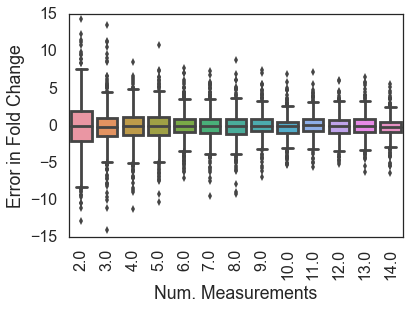

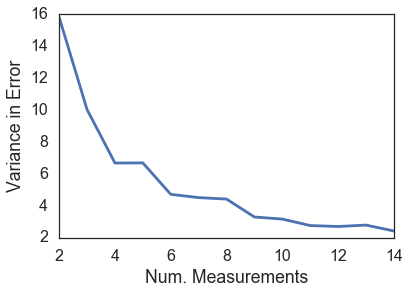

In [43]:
if n_genotypes >= 500:
    sns.boxplot(data=errors_df, x='num_measurements', y='error_means')
    ax = plt.gca()
    labels = ax.get_xticklabels()
    # plt.xticks(x=sorted(list(set(errors_df['num_measurements']))), )
    plt.xticks(rotation=90)
    plt.ylabel('Error in Fold Change')
    plt.xlabel('Num. Measurements')
    plt.savefig('../figures/error-means.pdf', bbox_inches='tight')
    
    errors_df.groupby('num_measurements').var().plot(legend=False)
    plt.ylabel('Variance in Error')
    plt.xlabel('Num. Measurements')
    plt.savefig('../figures/var-error-means.pdf', bbox_inches='tight')

In [44]:
(trace['fold'].mean(axis=0) - means).mean()

-0.023556495484220639

In [45]:
if n_genotypes <= 15:
    plt.figure()
    pm.traceplot(trace, varnames=['fold'])
    plt.figure()

# Compare modelled to actual

In [46]:
trace['fold'].mean(axis=0)

array([ 67.53774301,  17.53276501,  14.71536645, ...,  79.38063456,
         0.91587567,  19.61100567])

In [47]:
trace['fold'].mean(axis=0).shape

(5002,)

In [48]:
np.arange(1, n_genotypes+3).shape

(5002,)

In [49]:
if n_genotypes <= 15:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    lower = trace['fold'].mean(axis=0) - np.percentile(trace['fold'], 2.5, axis=0)
    upper = np.percentile(trace['fold'], 97.5, axis=0) - trace['fold'].mean(axis=0)
    yerr_pos = [lower, upper]
    ax.errorbar(x=np.arange(1, n_genotypes+3), y=trace['fold'].mean(axis=0), 
                # y-error bars
                yerr=yerr_pos,
                # styling
                color='blue', ls='none', alpha=0.5, label='modeled',)
    ax.scatter(x=np.arange(1, n_genotypes+3), y=means, 
               # styling
               color=['red'] * (n_genotypes) + ['green'] + ['blue'], marker='o', s=100, label='true mean',)
    ax.errorbar(x=np.arange(1, n_genotypes+3), y=means,
               yerr=sds,
               color='red', ls='none', alpha=0.5, label='true var')
    ax.legend(loc='upper left', frameon=False)
    ax.hlines(xmin=0, xmax=n_genotypes+3, y=trace['fold'].mean(axis=0)[-2], linestyles='--', alpha=0.2)
    ax.hlines(xmin=0, xmax=n_genotypes+3, y=trace['fold'].mean(axis=0)[-1], alpha=0.2)
    ax.set_xlabel('genotype ID')
    ax.set_ylabel('fold change')
    # ax.set_xlim(, n_genotypes+2)

In [50]:
if n_genotypes <= 15:
    fig = plt.figure()
    pm.forestplot(trace, vline=1, varnames=['fold'])
print('just for checking the above plot...')

just for checking the above plot...


How often is the true mean inside the 95% HPD?

In [51]:
lower, upper = np.percentile(trace['fold'], [2.5, 97.5], axis=0)
lower, upper

(array([ 61.54492009,  15.27924437,  10.6365609 , ...,  74.77374509,
          0.84788347,  18.7979149 ]),
 array([ 73.2330488 ,  19.97540183,  19.45178829, ...,  83.64297428,
          0.98384275,  20.469265  ]))

In [52]:
means

array([ 62.        ,  17.        ,  16.        , ...,  80.        ,
         0.91893758,  19.58636014])

In [53]:
# Here is the fraction of means that have been correctly included within the 95% HPD.
sum((means > lower) *  (means < upper)) / len(means)

0.90843662534986003

How many Z-factors are have their 95% HPD above the 0.5 line?

In [73]:
z_fact = trace['z_factor']
z_fact_mean = trace['z_factor'].mean(axis=0)
z_fact_lower = np.percentile(z_fact, 2.5, axis=0)
false_hits = (z_fact_lower < 0.5) * (z_fact_mean > 0.5)
true_hits = (z_fact_lower > 0.5) * (z_fact_mean > 0.5)

false_hit_rate = false_hits.sum() / len(false_hits)
false_hit_rate

0.16896620675864826

In [75]:
false_hit_prob = false_hits.sum() / (true_hits.sum() + false_hits.sum())
false_hit_prob

0.36595928973581637

In [76]:
true_hit_prob = true_hits.sum() / (true_hits.sum() + false_hits.sum())
true_hit_prob

0.63404071026418363